In [341]:
# 导入数据集
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据集
data = pd.read_csv('vgsales.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [342]:
#检查是否有缺失值
data.isna().any()
data.loc[(data['Year'].isna()) | (data['Publisher'].isna()),['Year','Publisher']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 307 entries, 179 to 16553
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       36 non-null     float64
 1   Publisher  249 non-null    object 
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


In [345]:
#缺失值不多，直接删去，并重新计算排名
data = data.loc[~((data['Year'].isna()) | (data['Publisher'].isna())),:]
data['Rank'] = data['Rank'].rank().astype(int)
data['Year'] = data['Year'].astype(int)
#保存清洗后数据集
data.to_csv('cleaned_data.csv', index=False)


启动hdfs![alt text](photo/image_1.png)
导入数据到hdfs[alt text](photo/image.png)

In [347]:
# 字体设置
plt.rcParams['font.sans-serif'] = ['Noto Serif CJK JP']  
# 设置颜色方案，与示例图保持一致
colors = ['#8884d8', '#82ca9d', '#ffc658', '#ff8042', '#a4de6c', 
          '#d0ed57', '#83a6ed', '#8dd1e1', '#6ab7ff', '#f08080','#81d8cf']
#导入findspark
import findspark
findspark.init('/usr/local/spark')  # 确保 Spark 环境正确
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import logging
# 创建 SparkSession
spark = SparkSession.builder \
    .appName("PySpark Jupyter") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()
# 获取 SparkContext
sc = spark.sparkContext
# 设置 PySpark 日志级别
sc.setLogLevel("ERROR")
# 获取 log4j 日志对象
log4j_logger = sc._jvm.org.apache.log4j
log4j_logger.LogManager.getRootLogger().setLevel(log4j_logger.Level.ERROR)
# 设置 Python 端的日志级别（避免 py4j 产生过多 INFO 日志）
logging.getLogger("py4j").setLevel(logging.ERROR)
print("PySpark 环境已配置，日志级别已设置为 ERROR")
# 测试是否工作正常
print(f"Spark 版本: {sc.version}")
test_rdd = sc.parallelize([1, 2, 3, 4, 5])
print(test_rdd.map(lambda x: x * 2).collect())

PySpark 环境已配置，日志级别已设置为 ERROR
Spark 版本: 3.4.4
[2, 4, 6, 8, 10]


In [348]:
#使用spark.read.csv()直接读取CSV文件
sdf = spark.read.csv('hdfs://localhost:9000/qimo/cleaned_data.csv', header=True, inferSchema=True)
# 创建视图以进行SQL操作
sdf.createOrReplaceTempView("df")

In [349]:
result = spark.sql("SELECT * FROM df LIMIT 5")
result.show()

+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports| Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo|   11.27|    8.89|   10.22|        1.0|       31.37|
+----+--------------------+--------+----+------------+---------+

In [350]:
# 3. 描述性统计分析
print("\n销售数据基本统计量:")
sdf.select("NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales").summary().show()


销售数据基本统计量:
+-------+-------------------+-------------------+-------------------+-------------------+------------------+
|summary|           NA_Sales|           EU_Sales|           JP_Sales|        Other_Sales|      Global_Sales|
+-------+-------------------+-------------------+-------------------+-------------------+------------------+
|  count|              16287|              16287|              16287|              16287|             16287|
|   mean|0.26569533984161153|0.14776754466755918|0.07884938908331204|0.04843679007796921|0.5410222877141792|
| stddev| 0.8225252142803904| 0.5093602084265009|0.31191601826952464|0.19010493697165343| 1.567519581894777|
|    min|                0.0|                0.0|                0.0|                0.0|              0.01|
|    25%|                0.0|                0.0|                0.0|                0.0|              0.06|
|    50%|               0.08|               0.02|                0.0|               0.01|              0.17|
|    75

In [351]:
# 全球销量最高的10款游戏
print("\n全球销量最高的10款游戏:")
top_games = sdf.select("Name", "Platform", "Year", "Genre", "Publisher", "Global_Sales")\
   .orderBy("Global_Sales", ascending=False)\
   .limit(20)
top_games.show(10)

# 游戏平台分布
print("\n各平台游戏数量:")
platform_counts = sdf.groupBy("Platform").count().orderBy("count", ascending=False)
platform_counts.show()

# 游戏类型分布
print("\n各类型游戏数量:")
genre_counts = sdf.groupBy("Genre").count().orderBy("count", ascending=False)
genre_counts.show()


全球销量最高的10款游戏:
+--------------------+--------+----+------------+---------+------------+
|                Name|Platform|Year|       Genre|Publisher|Global_Sales|
+--------------------+--------+----+------------+---------+------------+
|          Wii Sports|     Wii|2006|      Sports| Nintendo|       82.74|
|   Super Mario Bros.|     NES|1985|    Platform| Nintendo|       40.24|
|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo|       35.82|
|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo|        33.0|
|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo|       31.37|
|              Tetris|      GB|1989|      Puzzle| Nintendo|       30.26|
|New Super Mario B...|      DS|2006|    Platform| Nintendo|       30.01|
|            Wii Play|     Wii|2006|        Misc| Nintendo|       29.02|
|New Super Mario B...|     Wii|2009|    Platform| Nintendo|       28.62|
|           Duck Hunt|     NES|1984|     Shooter| Nintendo|       28.31|
+--------------------+--------+----+

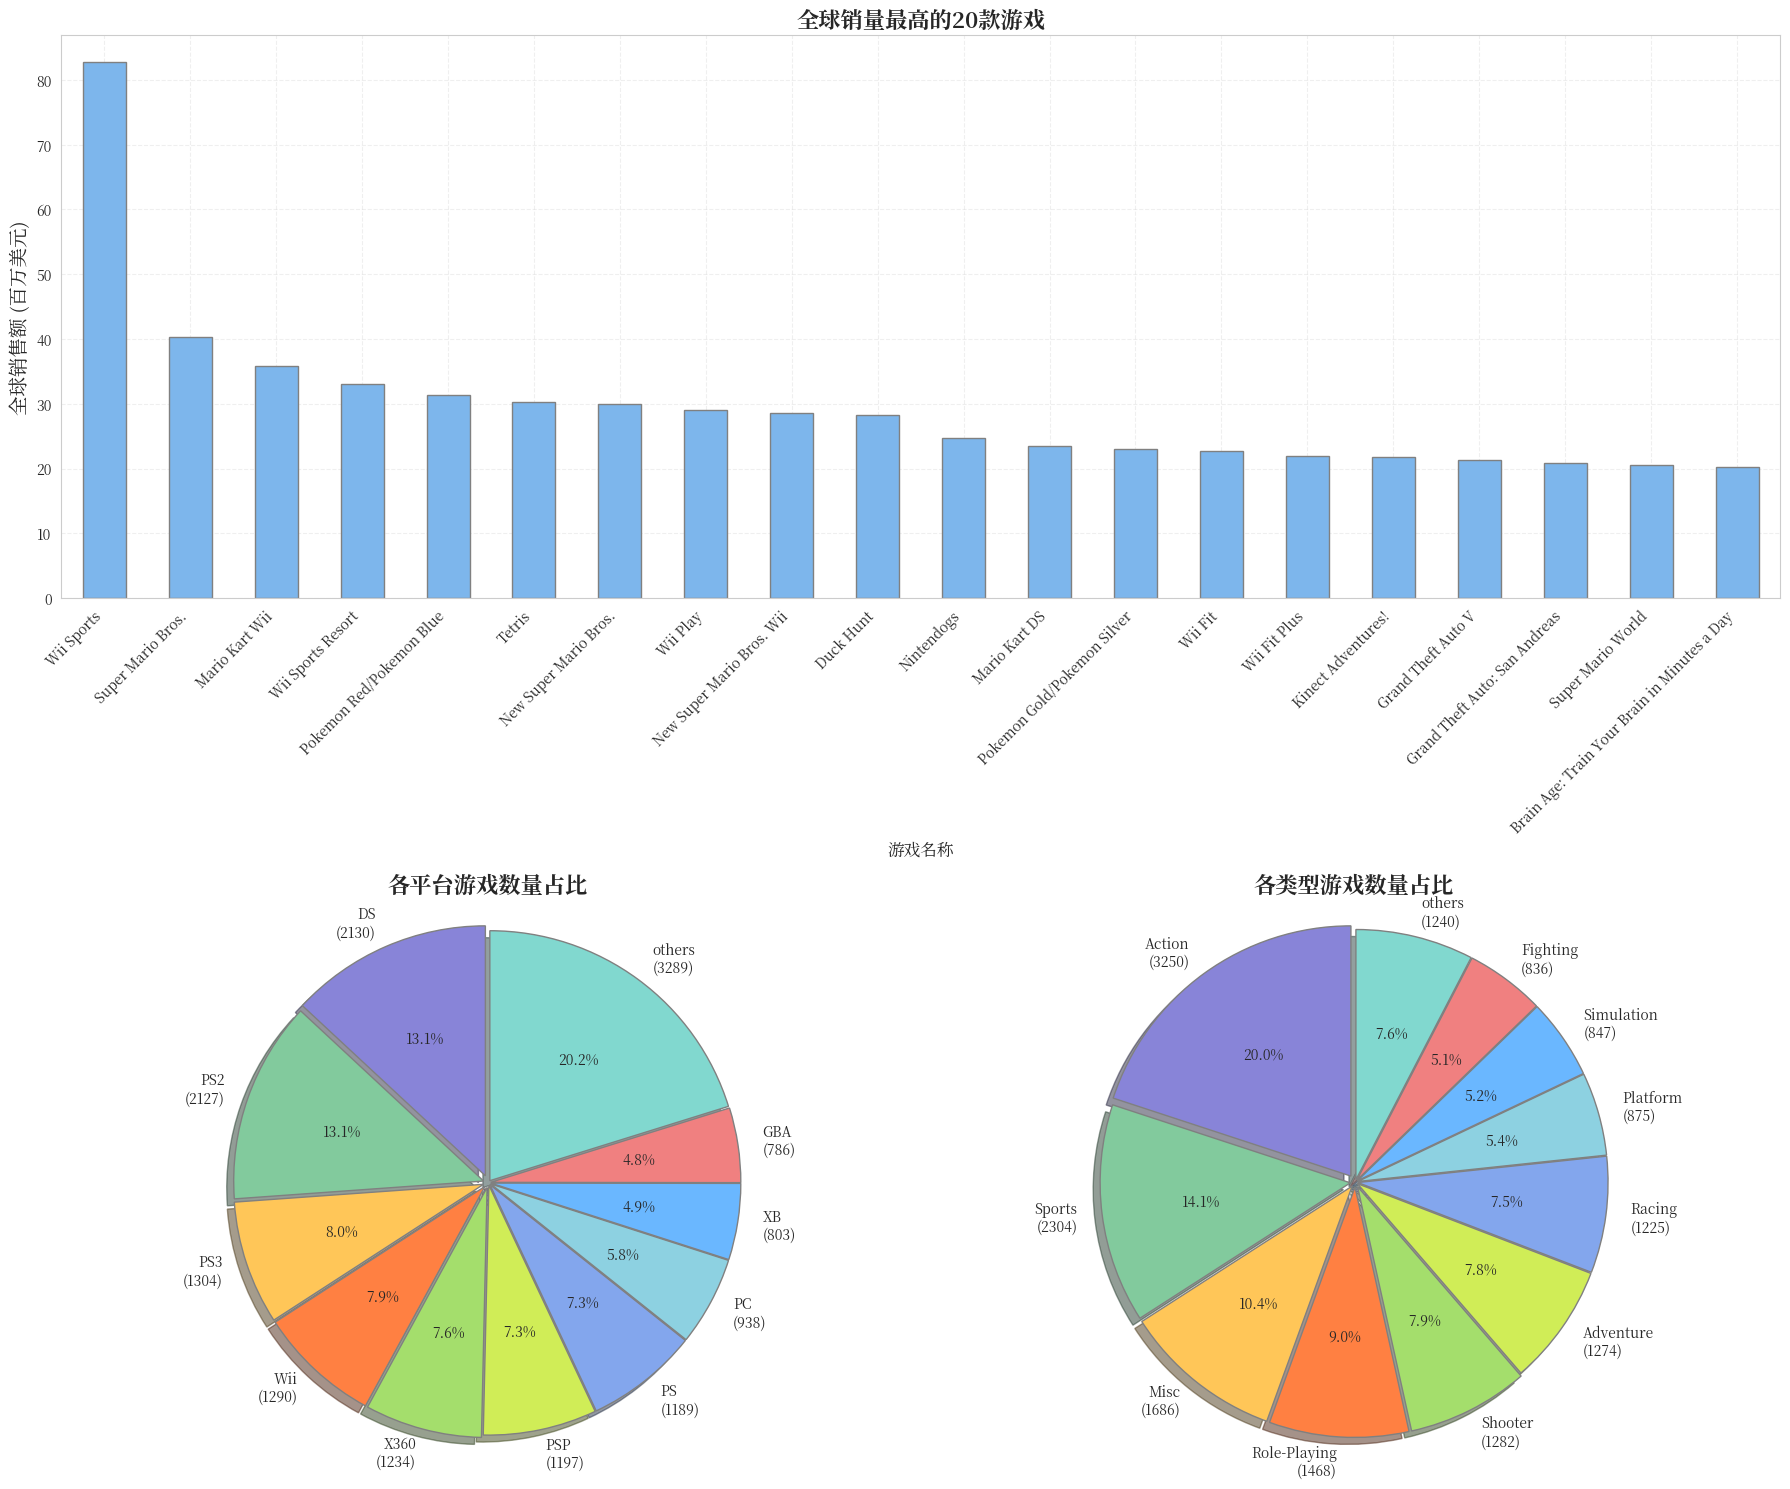

In [352]:
top_games_df = top_games.toPandas()
platform_counts_df = platform_counts.toPandas()
genre_counts_df = genre_counts.toPandas()
# 1. 全球销量最高的10款游戏
fig = plt.figure(figsize=(18, 15), dpi=100)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
bars = sns.barplot(x='Name', y='Global_Sales', data=top_games_df, color=colors[8], ax=ax1, width=0.5)
ax1.set_title('全球销量最高的20款游戏', fontsize=16, fontweight='bold')
ax1.set_xlabel('游戏名称', fontsize=12)
ax1.set_xticks(top_games_df['Name'])
ax1.set_xticklabels(top_games_df['Name'], rotation=45, ha='right')
ax1.set_ylabel('全球销售额 (百万美元)', fontsize=14)
for i in bars.patches:
    i.set_edgecolor('Grey')
ax1.grid(True, linestyle='--', alpha=0.3)

# 2. 各平台游戏数量
ax2 = plt.subplot2grid((2, 2), (1, 0))
# 处理前10个平台，将其余归为"其他"
top_10_platforms = platform_counts_df.iloc[:10]
other_platforms_count = platform_counts_df.iloc[10:]['count'].sum()

# 如果有"其他"类别，则添加到数据中
if other_platforms_count > 0:
    platform_data = top_10_platforms['count'].tolist() + [other_platforms_count]
    platform_labels = top_10_platforms['Platform'].tolist() + ['others']
else:
    platform_data = top_10_platforms['count'].tolist()
    platform_labels = top_10_platforms['Platform'].tolist()

labels = [f"{platform_labels[i]}\n({platform_data[i]})" for i in range(len(platform_labels))]
explode = (0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
wedges, texts, autotexts = ax2.pie(
    platform_data,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,
    explode=explode,
    wedgeprops={'edgecolor': 'grey'}
)
ax2.set_title('各平台游戏数量占比', fontsize=16, fontweight='bold')
ax2.axis('equal')  # 确保饼图是圆形的

# 3. 各类型游戏数量
ax3 = plt.subplot2grid((2, 2), (1, 1))
# 处理前10个类型，将其余归为"其他"
top_10_genres = genre_counts_df.iloc[:10]
other_genres_count = genre_counts_df.iloc[10:]['count'].sum()

# 如果有"其他"类别，则添加到数据中
if other_genres_count > 0:
    genre_data = top_10_genres['count'].tolist() + [other_genres_count]
    genre_labels = top_10_genres['Genre'].tolist() + ['others']
else:
    genre_data = top_10_genres['count'].tolist()
    genre_labels = top_10_genres['Genre'].tolist()

labels = [f"{genre_labels[i]}\n({genre_data[i]})" for i in range(len(genre_labels))]
ax3.pie(
    genre_data,
    labels=labels,
    explode=explode,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True,
    wedgeprops={'edgecolor': 'grey'}
)
ax3.set_title('各类型游戏数量占比', fontsize=16, fontweight='bold')
ax3.axis('equal')  # 确保饼图是圆形的

# 调整布局
plt.tight_layout()
plt.show()

In [353]:
# 4. 趋势分析
# 按年份统计游戏发行量和平均销售额
print("\n年度游戏发行量和平均销售额:")
yearly_stats = sdf.groupBy("Year") \
    .agg(
        F.count("Name").alias("Game_Count"),
        F.round(F.avg("Global_Sales"), 2).alias("Avg_Global_Sales")
    ) \
    .orderBy("Year", ascending=True)
yearly_stats.show()


年度游戏发行量和平均销售额:
+----+----------+----------------+
|Year|Game_Count|Avg_Global_Sales|
+----+----------+----------------+
|1980|         9|            1.26|
|1981|        46|            0.78|
|1982|        36|             0.8|
|1983|        17|            0.99|
|1984|        14|             3.6|
|1985|        14|            3.85|
|1986|        21|            1.77|
|1987|        16|            1.36|
|1988|        15|            3.15|
|1989|        17|            4.32|
|1990|        16|            3.09|
|1991|        41|            0.79|
|1992|        43|            1.77|
|1993|        60|            0.77|
|1994|       121|            0.65|
|1995|       219|             0.4|
|1996|       263|            0.76|
|1997|       289|             0.7|
|1998|       379|            0.68|
|1999|       338|            0.74|
+----+----------+----------------+
only showing top 20 rows



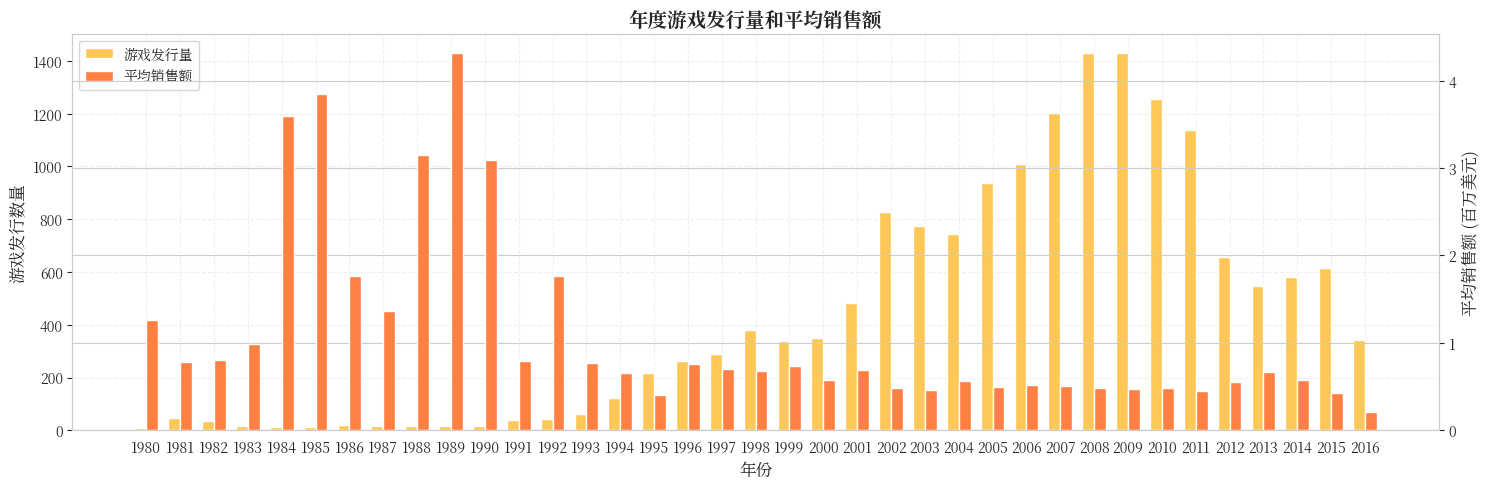

In [354]:
yearly_stats_pd = yearly_stats.toPandas()
# 创建图形
fig, ax1 = plt.subplots(figsize=(15, 5), dpi=100)
x = np.arange(len(yearly_stats_pd['Year']))
width = 0.35  # 柱子的宽度

# 第一个y轴：游戏发行量
bars1 = ax1.bar(x - width/2, yearly_stats_pd['Game_Count'], width, label='游戏发行量', color=colors[2])
ax1.set_ylabel('游戏发行数量', fontsize=12)
ax1.set_xlabel('年份', fontsize=12)
ax1.set_title('年度游戏发行量和平均销售额', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(yearly_stats_pd['Year'])

# 创建第二个y轴：平均销售额
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, yearly_stats_pd['Avg_Global_Sales'], width, label='平均销售额', color=colors[3])
ax2.set_ylabel('平均销售额 (百万美元)', fontsize=12)

# 添加图例
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# 添加网格线
ax1.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [355]:
#使用sql语句查询数据
# 各平台的总销售额
print("\n各平台的总销售额:")
platform_sales = spark.sql("select Platform, round(sum(Global_Sales),2) as Platform_Sales from df group by Platform order by Platform_Sales desc")
platform_sales.show()

# 各游戏类型的总销售额
print("\n各游戏类型的总销售额:")
genre_sales = spark.sql("select Genre, round(sum(Global_Sales),2) as Genre_Sales from df group by Genre order by Genre_Sales desc")
genre_sales.show()

# 各发行商的总销售额 (Top 15)
print("\n销售额最高的15家发行商:")
publisher_sales = spark.sql("select Publisher, round(sum(Global_Sales),2) as Publisher_Sales from df group by Publisher order by Publisher_Sales desc")
publisher_sales.show(15)



各平台的总销售额:
+--------+--------------+
|Platform|Platform_Sales|
+--------+--------------+
|     PS2|       1233.46|
|    X360|         969.6|
|     PS3|        949.35|
|     Wii|        909.81|
|      DS|        818.62|
|      PS|        727.39|
|     GBA|        305.62|
|     PSP|        291.71|
|     PS4|        278.07|
|      PC|         254.7|
|      GB|        254.42|
|      XB|        252.09|
|     NES|        251.07|
|     3DS|        246.27|
|     N64|        218.21|
|    SNES|        200.05|
|      GC|        197.14|
|    XOne|        141.06|
|    2600|         86.57|
|    WiiU|         81.86|
+--------+--------------+
only showing top 20 rows


各游戏类型的总销售额:
+------------+-----------+
|       Genre|Genre_Sales|
+------------+-----------+
|      Action|    1722.83|
|      Sports|    1309.24|
|     Shooter|     1026.2|
|Role-Playing|     923.79|
|    Platform|     829.13|
|        Misc|     789.87|
|      Racing|     726.76|
|    Fighting|     444.05|
|  Simulation|     389.69|
| 

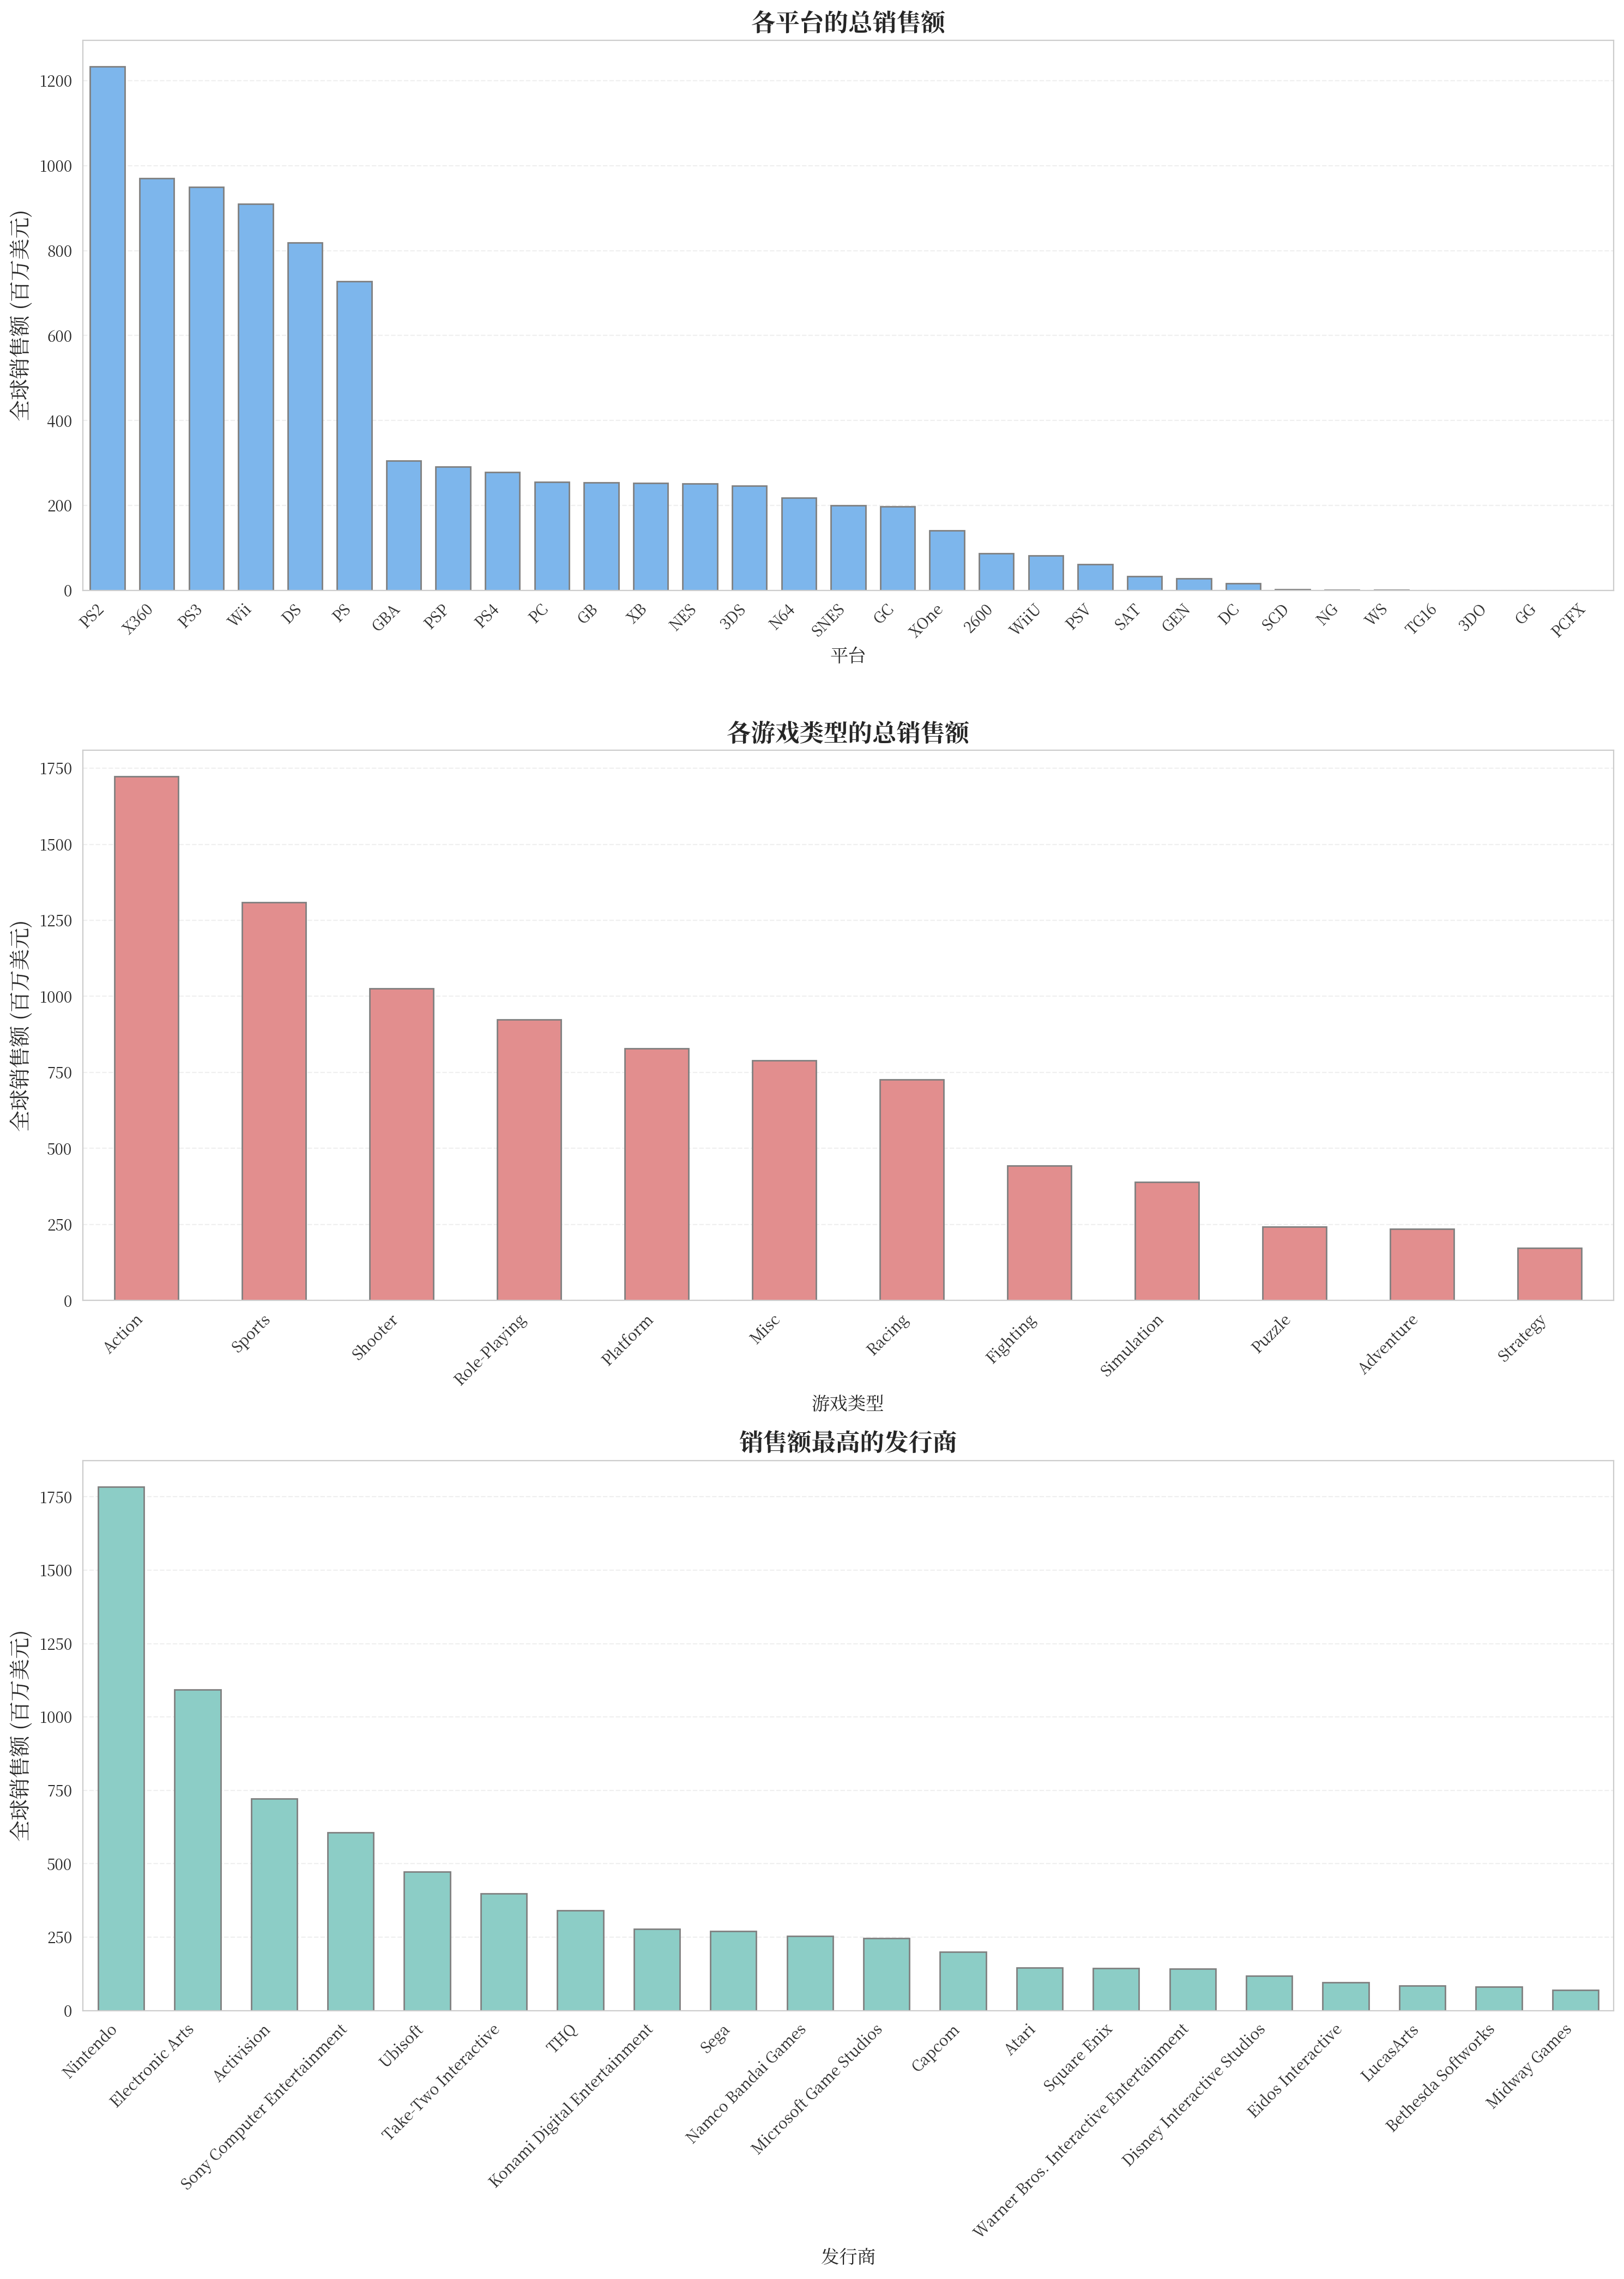

In [356]:
platform_sales_df = platform_sales.toPandas()
genre_sales_df = genre_sales.toPandas()
publisher_sales_df = publisher_sales.toPandas()
# 1. 各平台的总销售额
fig = plt.figure(figsize=(15, 21), dpi=200)
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
bars = sns.barplot(x='Platform', y='Platform_Sales', data=platform_sales_df, color=colors[8], ax=ax1, width=0.7)
ax1.set_title('各平台的总销售额', fontsize=16, fontweight='bold')
ax1.set_xlabel('平台', fontsize=12)
ax1.set_ylabel('全球销售额 (百万美元)', fontsize=14)
ax1.set_xticks(platform_sales_df['Platform'])
ax1.set_xticklabels(platform_sales_df['Platform'], rotation=45, ha='right')
for i in bars.patches:
    i.set_edgecolor('Grey')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# 2. 各游戏类型的总销售额
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
bars = sns.barplot(x='Genre', y='Genre_Sales', data=genre_sales_df, color=colors[9], ax=ax2, width=0.5)
ax2.set_title('各游戏类型的总销售额', fontsize=16, fontweight='bold')
ax2.set_xlabel('游戏类型', fontsize=12)
ax2.set_ylabel('全球销售额 (百万美元)', fontsize=14)
ax2.set_xticks(genre_sales_df['Genre'])
ax2.set_xticklabels(genre_sales_df['Genre'], rotation=45, ha='right')
for i in bars.patches:
    i.set_edgecolor('Grey')
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# 3. 销售额最高的15家发行商
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
bars = sns.barplot(x='Publisher', y='Publisher_Sales', data=publisher_sales_df.iloc[:20,:], color=colors[10], ax=ax3, width=0.6)
ax3.set_title('销售额最高的发行商', fontsize=16, fontweight='bold')
ax3.set_ylabel('全球销售额 (百万美元)', fontsize=14)
ax3.set_xlabel('发行商', fontsize=12)
ax3.set_xticks(publisher_sales_df.iloc[:20,:]['Publisher'])
ax3.set_xticklabels(publisher_sales_df.iloc[:20,:]['Publisher'], rotation=45, ha='right')
for i in bars.patches:
    i.set_edgecolor('Grey')
ax3.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [357]:
# 6. 地区差异分析
# 各地区销售总额
print("\n各地区销售总额:")
region_sales = spark.sql("select round(sum(NA_Sales), 2) as North_America, round(sum(EU_Sales), 2) as Europe, round(sum(JP_Sales), 2) as Japan, round(sum(Other_Sales), 2) as Other_Regions from df")
region_sales.show()

# 各地区最受欢迎的游戏类型
print("\n北美地区最受欢迎的游戏类型:")
na_genre = spark.sql("select Genre, round(sum(NA_Sales), 2) as NA_Total_Sales from df group by Genre order by NA_Total_Sales desc")
na_genre.show()

print("\n欧洲地区最受欢迎的游戏类型:")
eu_genre = spark.sql("select Genre, round(sum(EU_Sales), 2) as EU_Total_Sales from df group by Genre order by EU_Total_Sales desc")
eu_genre.show()


print("\n日本地区最受欢迎的游戏类型:")
jp_genre = spark.sql("select Genre, round(sum(JP_Sales), 2) as JP_Total_Sales from df group by Genre order by JP_Total_Sales desc")
jp_genre.show()


各地区销售总额:
+-------------+-------+-------+-------------+
|North_America| Europe|  Japan|Other_Regions|
+-------------+-------+-------+-------------+
|      4327.38|2406.69|1284.22|       788.89|
+-------------+-------+-------+-------------+


北美地区最受欢迎的游戏类型:
+------------+--------------+
|       Genre|NA_Total_Sales|
+------------+--------------+
|      Action|        861.77|
|      Sports|        670.09|
|     Shooter|        575.16|
|    Platform|        445.99|
|        Misc|        396.92|
|      Racing|        356.93|
|Role-Playing|         326.5|
|    Fighting|        220.74|
|  Simulation|        181.51|
|      Puzzle|        122.01|
|   Adventure|        101.93|
|    Strategy|         67.83|
+------------+--------------+


欧洲地区最受欢迎的游戏类型:
+------------+--------------+
|       Genre|EU_Total_Sales|
+------------+--------------+
|      Action|        516.48|
|      Sports|        371.34|
|     Shooter|        310.45|
|      Racing|        236.31|
|        Misc|        211.77|
|    P

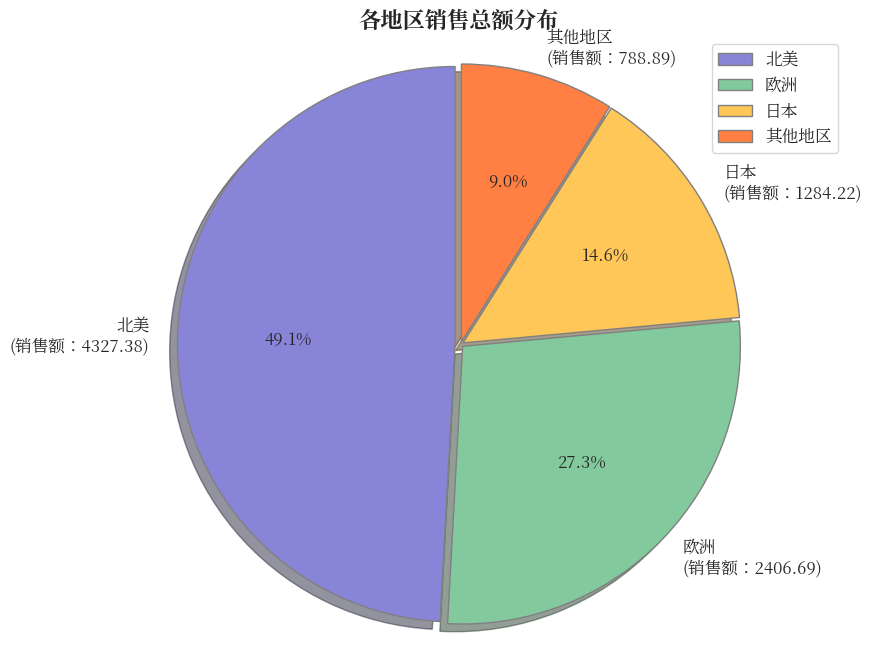

In [358]:
#各地区销售额占比
regions = ["北美", "欧洲", "日本", "其他地区"]
sales = region_sales.toPandas().iloc[0,:]
explode = (0.02, 0.01, 0.01, 0.01)  
labels = [f"{regions[i]}\n(销售额：{sales.iloc[i]})" for i in range(len(regions))]

# 创建饼图
plt.figure(figsize=(10, 8), dpi=100)
plt.pie(sales, explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90,
        textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'grey'})

plt.title('各地区销售总额分布', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.legend(regions, loc="best", fontsize=12)
plt.show()

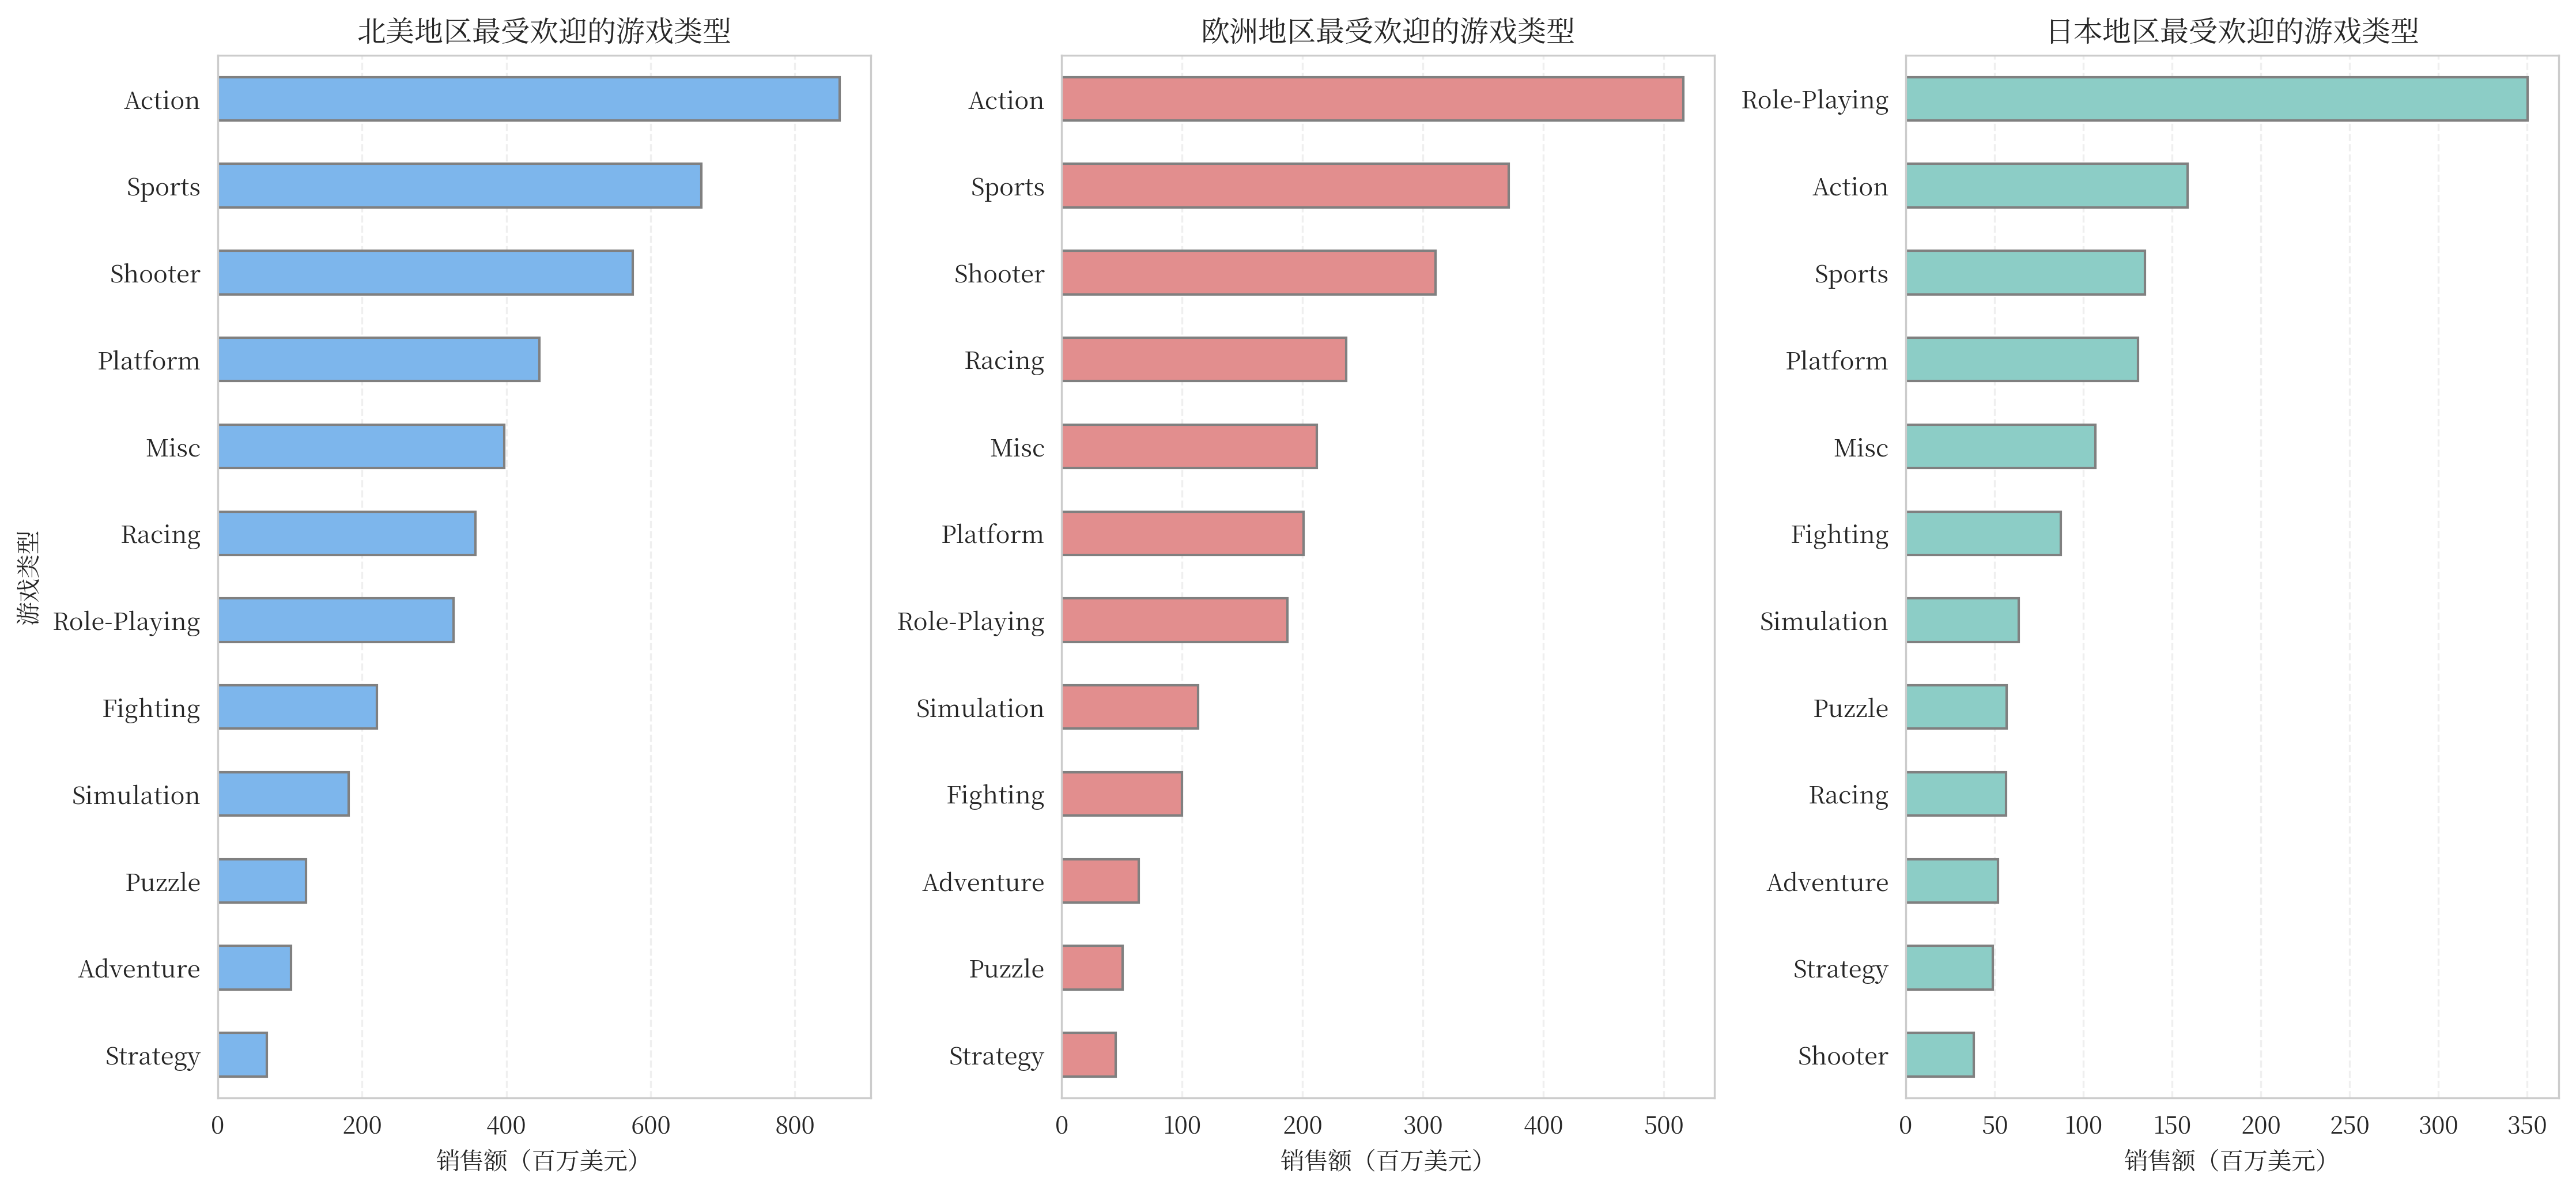

In [359]:
na_genre_df = na_genre.toPandas()
eu_genre_df = eu_genre.toPandas()
jp_genre_df = jp_genre.toPandas()

fig = plt.figure(figsize=(15, 7), dpi=300)
#1.北美地区最受欢迎的游戏类型
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
bar1 = sns.barplot(x='NA_Total_Sales', y='Genre', data=na_genre_df, ax=ax1, width=0.5, color=colors[8])
ax1.set_title('北美地区最受欢迎的游戏类型')
ax1.set_xlabel('销售额（百万美元）')
ax1.set_ylabel('游戏类型')
for i in bar1.patches:
    i.set_edgecolor('grey')
ax1.grid(axis='x', linestyle='--', alpha=0.3)
#2.欧洲地区最受欢迎的游戏类型
ax2 = plt.subplot2grid((2, 3), (0, 1), rowspan=2)
bar2 = sns.barplot(x='EU_Total_Sales', y='Genre', data=eu_genre_df, ax=ax2, width=0.5, color=colors[9])
ax2.set_title('欧洲地区最受欢迎的游戏类型')
ax2.set_xlabel('销售额（百万美元）')
ax2.set_ylabel('')
for i in bar2.patches:
    i.set_edgecolor('grey')
ax2.grid(axis='x', linestyle='--', alpha=0.3)
#3.日本地区最受欢迎的游戏类型
ax3 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
bar3 = sns.barplot(x='JP_Total_Sales', y='Genre', data=jp_genre_df, ax=ax3, width=0.5, color=colors[10])
ax3.set_title('日本地区最受欢迎的游戏类型')
ax3.set_xlabel('销售额（百万美元）')
ax3.set_ylabel('')
for i in bar3.patches:
    i.set_edgecolor('grey')
ax3.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [360]:
#使用 Spark MLlib 组件进行数据分析